# Lowess_simulations.ipynb

2020.12.06
https://github.com/MikLang/Lowess_simulation/blob/master/Lowess_simulations.py

In [5]:
import pandas as pd               # Pandas handles dataframes
import numpy as np
import scipy
import matplotlib                 # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns             # Seaborn for beautiful plots
import statsmodels


def loc_eval(x, b):
    loc_est = 0
    for i in enumerate(b): loc_est+=i[1]*(x**i[0])
    return(loc_est)


def loess(xvals, yvals, data, alpha, poly_degree=1):
    all_data = sorted(zip(data[xvals].tolist(), data[yvals].tolist()), key=lambda x: x[0])
    xvals, yvals = zip(*all_data)
    evalDF = pd.DataFrame(columns=['v','g'])
    n = len(xvals)
    m = n + 1
    q = int(np.floor(n * alpha) if alpha <= 1.0 else n)
    avg_interval = ((max(xvals)-min(xvals))/len(xvals))
    v_lb = min(xvals)-(.5*avg_interval)
    v_ub = (max(xvals)+(.5*avg_interval))
    v = enumerate(np.linspace(start=v_lb, stop=v_ub, num=m), start=1)
    xcols = [np.ones_like(xvals)]
    for j in range(1, (poly_degree + 1)):
        xcols.append([i ** j for i in xvals])
    X = np.vstack(xcols).T
    for i in v:
        iterpos = i[0]
        iterval = i[1]
        iterdists = sorted([(j, np.abs(j-iterval)) for j in xvals], key=lambda x: x[1])
        _, raw_dists = zip(*iterdists)
        scale_fact = raw_dists[q-1]
        scaled_dists = [(j[0],(j[1]/scale_fact)) for j in iterdists]
        weights = [(j[0],((1-np.abs(j[1]**3))**3 if j[1]<=1 else 0)) for j in scaled_dists]
        _, weights      = zip(*sorted(weights,     key=lambda x: x[0]))
        _, raw_dists    = zip(*sorted(iterdists,   key=lambda x: x[0]))
        _, scaled_dists = zip(*sorted(scaled_dists,key=lambda x: x[0]))
        W         = np.diag(weights)
        b         = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ yvals)
        local_est = loc_eval(iterval, b)
        iterDF2   = pd.DataFrame({
                       'v'  :[iterval],
                       'g'  :[local_est]
                       })
        evalDF = pd.concat([evalDF, iterDF2])
    evalDF = evalDF[['v','g']]
    return(evalDF)


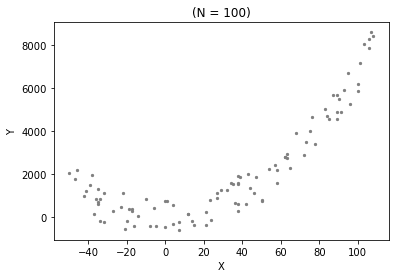

In [6]:
np.random.seed(10)

# N=10000
N=100
x_values = np.random.randint(-50,110,size=(N))
y_values = np.square(x_values)/1.5 + np.random.randint(-1000,1000, size=len(x_values))
df = pd.DataFrame({"Xvalue" : x_values,
                    "Yvalue" : y_values
                    })

# Scatterplot
plt.scatter(df["Xvalue"], df["Yvalue"], color="grey", marker="o", s=5)
plt.xlabel("X"), plt.ylabel("Y")
plt.title('(N = 100)')
plt.show()


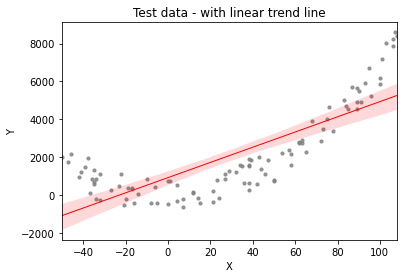

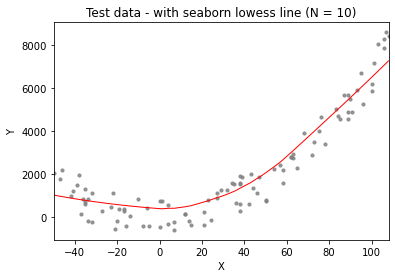

In [7]:
# Create linear trend line
sns.regplot("Xvalue", "Yvalue", data=df,  color="grey", scatter_kws={"s": 10},
             line_kws={"color":"r","alpha":1,"lw":1} ,fit_reg=True)
plt.xlabel("X"), plt.ylabel("Y")
plt.title('Test data - with linear trend line')
plt.show()

# Seaborne solution:
sns.regplot("Xvalue", "Yvalue", data=df,  color="grey", scatter_kws={"s": 10},
             line_kws={"color":"r","alpha":1,"lw":1} ,lowess=True)
plt.xlabel("X"), plt.ylabel("Y")
plt.title('Test data - with seaborn lowess line (N = 10)')
plt.show()

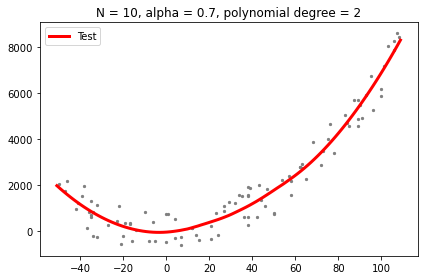

In [9]:
evalDF = loess("Xvalue", "Yvalue", data = df, alpha=0.7, poly_degree=2)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(df["Xvalue"], df["Yvalue"], color="grey", marker="o", s=5, label="_nolegend_")
ax1.plot(evalDF['v'], evalDF['g'], color='red', linewidth= 3, label="Test")
plt.title('N = 10, alpha = 0.7, polynomial degree = 2')
plt.legend()
plt.tight_layout()
plt.show()